**Leukemia Classification** Using Convaluted Neural 


In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from numpy import savetxt
from IPython.display import Image

import pickle

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score


from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
# For reproducibility
np.random.seed(42)
from numpy.random import seed
seed(42)

In [3]:
# Mounting G-Drive FOLDER
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Checking data folder
!ls /content/drive/MyDrive/datasets/hotdog-nothotdog/train

'1 nothotdog'  '2 hotdog'


In [5]:
# Creating train_ds and val_ds for model
# This will go through the folder and find photos and classify them based on folder location
# ie. if in all folder will label all (1)
train_ds = image_dataset_from_directory(
    '/content/drive/MyDrive/datasets/hotdog-nothotdog/train/', # Directory
    image_size = (256, 256), # make sure all images are the same size
    batch_size = 32, # This will load 32 images at a time, memory can't hold them all
    seed = 42, # random seed for reproducibility
    validation_split = 0.2, 
    subset = 'training',
    label_mode = 'binary'
)

val_ds = image_dataset_from_directory(
    '/content/drive/MyDrive/datasets/hotdog-nothotdog/train/',
    image_size = (256, 256),
    batch_size = 32,
    seed = 42,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'binary'
)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.


In [6]:
# Calculating null model
print(f'Hot Dogs is {round(1500/3000,2)}%')
print(f'Not Hot Dogs is {round(1500/3000, 2)}%')

Hot Dogs is 0.5%
Not Hot Dogs is 0.5%


Our null model shows that if we were to guess Hot Dog for every image we would be right 50% of the time.

Text(0.5, 0.98, 'Hot Dog (0) Vs Not Hot Dog (1) Cells')

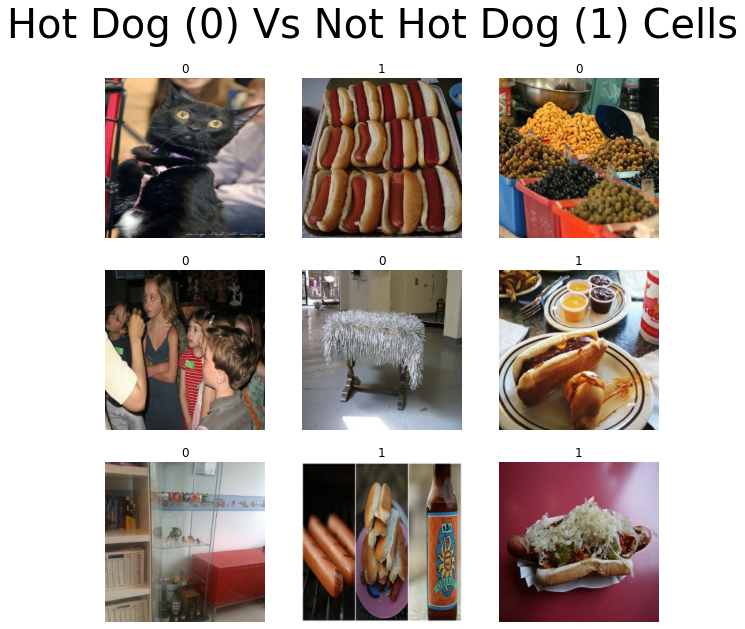

In [7]:
# Performing EDA on classes
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.suptitle('Hot Dog (0) Vs Not Hot Dog (1) Cells', fontsize = 40) 
#plt.savefig('/content/drive/MyDrive/ga_project_4/all_vs_hem_cells')

These images show what the dataset has labeled hot dog Vs not hot dog.

# Modeling images without data augmentation

In [8]:
# Base Model
model_b = Sequential()

model_b.add(layers.Input(shape = (256,256,3)))

# The 1. below garuntees we get a float for the normalization
model_b.add(layers.Rescaling(1./255))


# First convolution
model_b.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Passing into the max pooling layer
model_b.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Second Convolution
model_b.add(Conv2D(64, (3,3), activation='relu'))
model_b.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_b.add(Flatten())

# Fully Connected
model_b.add(Dense(64, activation='relu'))
model_b.add(Dense(1, activation='sigmoid'))

#Compile
model_b.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [9]:
# Fitting the model
h_b = model_b.fit(train_ds, validation_data= val_ds, epochs = 5, workers = 8)

Epoch 1/5
75/75 [==============================] - 150s 2s/step - loss: 0.9511 - accuracy: 0.5608 - val_loss: 0.6426 - val_accuracy: 0.5617
Epoch 2/5
75/75 [==============================] - 3s 31ms/step - loss: 0.6281 - accuracy: 0.6662 - val_loss: 0.6264 - val_accuracy: 0.6800
Epoch 3/5
75/75 [==============================] - 2s 31ms/step - loss: 0.5961 - accuracy: 0.6921 - val_loss: 0.6190 - val_accuracy: 0.6933
Epoch 4/5
75/75 [==============================] - 2s 31ms/step - loss: 0.5516 - accuracy: 0.7392 - val_loss: 0.6011 - val_accuracy: 0.6983
Epoch 5/5
75/75 [==============================] - 3s 32ms/step - loss: 0.5057 - accuracy: 0.7763 - val_loss: 0.6018 - val_accuracy: 0.7000


In [10]:
 # Scoring model
print(h_b.history['loss'][-1], h_b.history['val_loss'][-1])
print(h_b.history['accuracy'][-1], h_b.history['val_accuracy'][-1])

0.5056741237640381 0.6018323302268982
0.7762500047683716 0.699999988079071


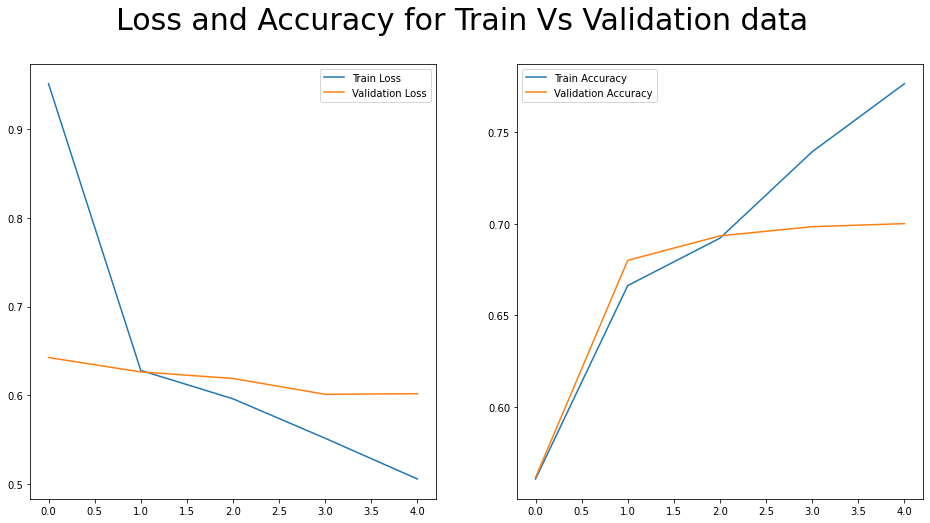

In [11]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Accuracy for Train Vs Validation data', fontsize =30)
figsize=(16,16),
ax1.plot(h_b.history['loss'], label = 'Train Loss'),
ax1.plot(h_b.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(h_b.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(h_b.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();
plt.savefig('/content/drive/MyDrive/ga_project_4/no_augmentation_plot')

The model is a bit overfit after only 5 epochs, runninhg more would surely cause it to become more overfit. There may be a way to improve the model and reduce the variance at the same time.


Data augmentation artificially introduces diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This can be helpful for both small datasets and preventing overfitting of a model. 

In [12]:
# Instantiating data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


Text(0.5, 0.98, 'Hot Dog with Augmentation Applied')

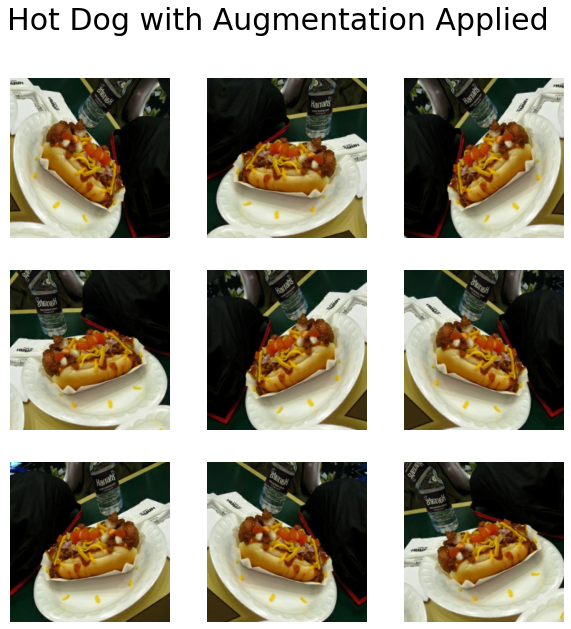

In [15]:
# Plotting one image with data augmentation applied
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.suptitle('Hot Dog with Augmentation Applied', fontsize = 30) 
#plt.savefig('/content/drive/MyDrive/ga_project_4/image_augmentation')

In [16]:
# Apply `data_augmentation` to the training images. Code adapted from https://keras.io/examples/vision/image_classification_from_scratch/
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization. 
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [17]:
# Base Model
model_1 = Sequential()

model_1.add(layers.Input(shape = (256,256,3)))

# The 1. below garuntees we get a float for the normalization
model_1.add(layers.Rescaling(1./255))


# First convolution
model_1.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Passing into the max pooling layer
model_1.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Second Convolution
model_1.add(Conv2D(64, (3,3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_1.add(Flatten())

# Fully Connected
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

#Compile
model_1.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [18]:
# Fitting augmented model with 5 epochs
h_1 = model_1.fit(train_ds, validation_data= val_ds, epochs = 5)

Epoch 1/5
75/75 [==============================] - 4s 46ms/step - loss: 0.8394 - accuracy: 0.6000 - val_loss: 0.6157 - val_accuracy: 0.6900
Epoch 2/5
75/75 [==============================] - 4s 49ms/step - loss: 0.6059 - accuracy: 0.6796 - val_loss: 0.6631 - val_accuracy: 0.6767
Epoch 3/5
75/75 [==============================] - 4s 44ms/step - loss: 0.6261 - accuracy: 0.6488 - val_loss: 0.5767 - val_accuracy: 0.7400
Epoch 4/5
75/75 [==============================] - 4s 44ms/step - loss: 0.5828 - accuracy: 0.6850 - val_loss: 0.5744 - val_accuracy: 0.7250
Epoch 5/5
75/75 [==============================] - 4s 46ms/step - loss: 0.5662 - accuracy: 0.7104 - val_loss: 0.6169 - val_accuracy: 0.6933


In [19]:
# Scoring model
print(h_1.history['loss'][-1], h_1.history['val_loss'][-1])
print(h_1.history['accuracy'][-1], h_1.history['val_accuracy'][-1])

0.5661916136741638 0.6169443130493164
0.7104166746139526 0.6933333277702332


The model is much less overfit due to the augmentation. 

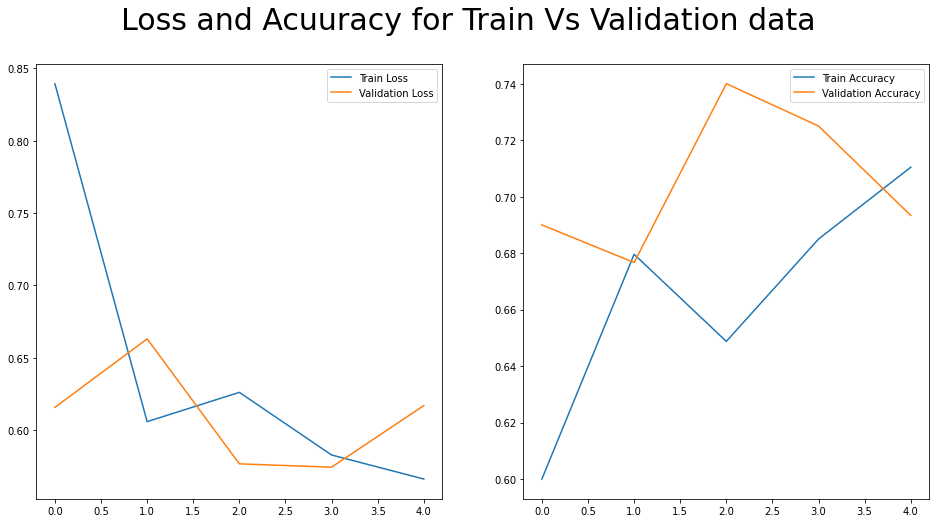

In [20]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Acuuracy for Train Vs Validation data', fontsize =30)
figsize=(16,16),
ax1.plot(h_1.history['loss'], label = 'Train Loss'),
ax1.plot(h_1.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(h_1.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(h_1.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();
plt.savefig('/content/drive/MyDrive/ga_project_4/with_image_augmentation')

Now trying the same model with more epochs.

In [31]:
# Base Model with 10 epochs
model_1_10 = Sequential()

model_1_10.add(layers.Input(shape = (256,256,3)))

# The 1. below garuntees we get a float for the normalization
model_1_10.add(layers.Rescaling(1./255))


# First convolution
model_1_10.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Passing into the max pooling layer
model_1_10.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Second Convolution
model_1_10.add(Conv2D(64, (3,3), activation='relu'))
model_1_10.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_1_10.add(Flatten())

# Fully Connected
model_1_10.add(Dense(64, activation='relu'))
model_1_10.add(Dense(1, activation='sigmoid'))

#Compile
model_1_10.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [34]:
# Fitting augmented model with 10 epochs
h_1_10 = model_1_10.fit(train_ds, validation_data= val_ds, epochs = 10)

Epoch 1/10
75/75 [==============================] - 4s 47ms/step - loss: 0.8465 - accuracy: 0.5467 - val_loss: 0.6322 - val_accuracy: 0.6500
Epoch 2/10
75/75 [==============================] - 4s 46ms/step - loss: 0.6528 - accuracy: 0.6225 - val_loss: 0.6417 - val_accuracy: 0.6600
Epoch 3/10
75/75 [==============================] - 4s 47ms/step - loss: 0.6300 - accuracy: 0.6475 - val_loss: 0.6325 - val_accuracy: 0.6917
Epoch 4/10
75/75 [==============================] - 4s 45ms/step - loss: 0.6368 - accuracy: 0.6446 - val_loss: 0.6102 - val_accuracy: 0.7067
Epoch 5/10
75/75 [==============================] - 4s 47ms/step - loss: 0.6038 - accuracy: 0.6854 - val_loss: 0.5899 - val_accuracy: 0.6967
Epoch 6/10
75/75 [==============================] - 4s 48ms/step - loss: 0.5813 - accuracy: 0.6967 - val_loss: 0.6002 - val_accuracy: 0.7100
Epoch 7/10
75/75 [==============================] - 4s 45ms/step - loss: 0.5665 - accuracy: 0.7017 - val_loss: 0.5940 - val_accuracy: 0.7267
Epoch 8/10
75

In [35]:
# Scoring model
print(h_1_10.history['loss'][-1], h_1_10.history['val_loss'][-1])
print(h_1_10.history['accuracy'][-1], h_1_10.history['val_accuracy'][-1])

0.5472713112831116 0.5591986179351807
0.7149999737739563 0.7250000238418579


In [39]:
# Base Model with 15 epochs
model_1_15 = Sequential()

model_1_15.add(layers.Input(shape = (256,256,3)))

# The 1. below garuntees we get a float for the normalization
model_1_15.add(layers.Rescaling(1./255))


# First convolution
model_1_15.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Passing into the max pooling layer
model_1_15.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Second Convolution
model_1_15.add(Conv2D(64, (3,3), activation='relu'))
model_1_15.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_1_15.add(Flatten())

# Fully Connected
model_1_15.add(Dense(64, activation='relu'))
model_1_15.add(Dense(1, activation='sigmoid'))

#Compile
model_1_15.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [40]:
# Tryin again with 15 epochs
# Fitting augmented model with 10 epochs
h_1_15 = model_1_15.fit(train_ds, validation_data= val_ds, epochs = 15)

Epoch 1/15
75/75 [==============================] - 4s 46ms/step - loss: 0.8743 - accuracy: 0.6000 - val_loss: 0.6568 - val_accuracy: 0.6433
Epoch 2/15
75/75 [==============================] - 4s 48ms/step - loss: 0.6228 - accuracy: 0.6633 - val_loss: 0.5991 - val_accuracy: 0.7433
Epoch 3/15
75/75 [==============================] - 4s 44ms/step - loss: 0.5929 - accuracy: 0.6767 - val_loss: 0.6064 - val_accuracy: 0.7150
Epoch 4/15
75/75 [==============================] - 4s 45ms/step - loss: 0.5722 - accuracy: 0.6954 - val_loss: 0.6075 - val_accuracy: 0.7100
Epoch 5/15
75/75 [==============================] - 4s 48ms/step - loss: 0.5785 - accuracy: 0.6913 - val_loss: 0.6565 - val_accuracy: 0.6383
Epoch 6/15
75/75 [==============================] - 4s 48ms/step - loss: 0.5625 - accuracy: 0.7067 - val_loss: 0.7120 - val_accuracy: 0.6700
Epoch 7/15
75/75 [==============================] - 4s 45ms/step - loss: 0.5664 - accuracy: 0.7146 - val_loss: 0.6104 - val_accuracy: 0.6900
Epoch 8/15
75

In [41]:
# Scoring model
print(h_1_15.history['loss'][-1], h_1_15.history['val_loss'][-1])
print(h_1_15.history['accuracy'][-1], h_1_15.history['val_accuracy'][-1])

0.4989447593688965 0.6865671277046204
0.753333330154419 0.6966666579246521


In [45]:
# Base Model with 8 epochs
model_1_8 = Sequential()

model_1_8.add(layers.Input(shape = (256,256,3)))

# The 1. below garuntees we get a float for the normalization
model_1_8.add(layers.Rescaling(1./255))


# First convolution
model_1_8.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Passing into the max pooling layer
model_1_8.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Second Convolution
model_1_8.add(Conv2D(64, (3,3), activation='relu'))
model_1_8.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_1_8.add(Flatten())

# Fully Connected
model_1_8.add(Dense(64, activation='relu'))
model_1_8.add(Dense(1, activation='sigmoid'))

#Compile
model_1_8.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [46]:
# Tryin again with 8 epochs
# Fitting augmented model with 10 epochs
h_1_8 = model_1_8.fit(train_ds, validation_data= val_ds, epochs = 8)

Epoch 1/8
75/75 [==============================] - 4s 46ms/step - loss: 0.8980 - accuracy: 0.5854 - val_loss: 0.6209 - val_accuracy: 0.6833
Epoch 2/8
75/75 [==============================] - 4s 46ms/step - loss: 0.6325 - accuracy: 0.6525 - val_loss: 0.5836 - val_accuracy: 0.7033
Epoch 3/8
75/75 [==============================] - 4s 47ms/step - loss: 0.6096 - accuracy: 0.6779 - val_loss: 0.5893 - val_accuracy: 0.7150
Epoch 4/8
75/75 [==============================] - 4s 45ms/step - loss: 0.5991 - accuracy: 0.6783 - val_loss: 0.6888 - val_accuracy: 0.6900
Epoch 5/8
75/75 [==============================] - 4s 46ms/step - loss: 0.5887 - accuracy: 0.6917 - val_loss: 0.6292 - val_accuracy: 0.6900
Epoch 6/8
75/75 [==============================] - 4s 47ms/step - loss: 0.5577 - accuracy: 0.7229 - val_loss: 0.5864 - val_accuracy: 0.7100
Epoch 7/8
75/75 [==============================] - 4s 46ms/step - loss: 0.5359 - accuracy: 0.7300 - val_loss: 0.6275 - val_accuracy: 0.7000
Epoch 8/8
75/75 [===

In [47]:
# Scoring model
print(h_1_8.history['loss'][-1], h_1_8.history['val_loss'][-1])
print(h_1_8.history['accuracy'][-1], h_1_8.history['val_accuracy'][-1])

0.521357536315918 0.5681349635124207
0.7408333420753479 0.7350000143051147


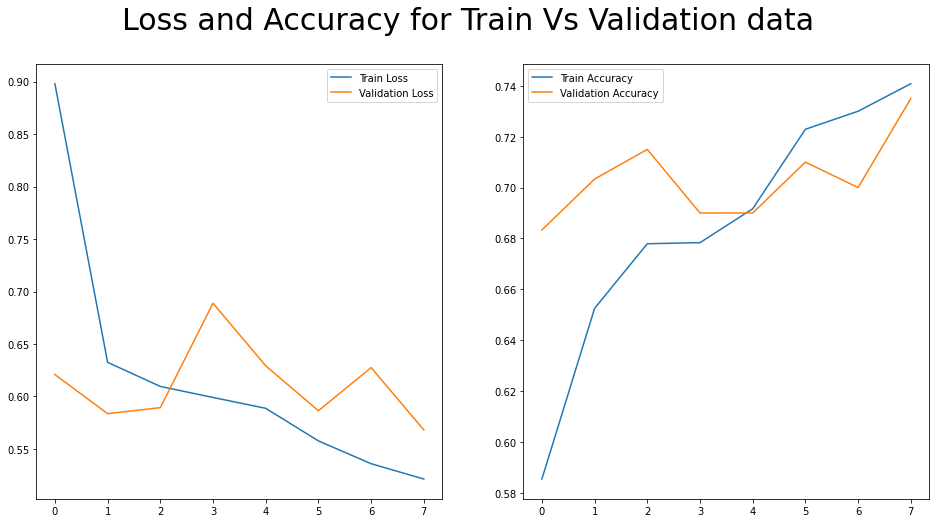

In [48]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Accuracy for Train Vs Validation data', fontsize = 30)
figsize=(16,16),
ax1.plot(h_1_8.history['loss'], label = 'Train Loss'),
ax1.plot(h_1_8.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(h_1_8.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(h_1_8.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();
#plt.savefig('/content/drive/MyDrive/ga_project_4/base_model_10_epochs')

# **Loading Transfer Learning Model**

In [49]:
# Inlcude top = false means it will not take the input layer, weights taken from the imagenet dataset, it has many classes
# and we just want a single output for this binary problem.
effnet = EfficientNetB0(include_top = False, weights = 'imagenet')

16705208/16705208 [==============================] - 2s 0us/step


In [50]:
# This will prevent the model from bein trained by our data as we want it to maintain the weights
effnet.trainable = False
effnet.trainable

False

In [51]:
# Transfer learning EfficientNetB0 model
model_2 = Sequential()
model_2.add(effnet)
model_2.add(GlobalAveragePooling2D())# Required, not 100% sure why but may be becasue of teh shape going into teh final layer, all it does is get teh shape right
# Flatten
model_2.add(Flatten())

# Fully Connected
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

#Compile
model_2.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [52]:
# Fitting the model
h_2 = model_2.fit(train_ds, validation_data= val_ds, epochs = 8)

Epoch 1/8
75/75 [==============================] - 11s 66ms/step - loss: 0.2358 - accuracy: 0.9067 - val_loss: 0.1526 - val_accuracy: 0.9400
Epoch 2/8
75/75 [==============================] - 4s 47ms/step - loss: 0.1281 - accuracy: 0.9529 - val_loss: 0.1491 - val_accuracy: 0.9500
Epoch 3/8
75/75 [==============================] - 4s 50ms/step - loss: 0.1058 - accuracy: 0.9646 - val_loss: 0.1380 - val_accuracy: 0.9517
Epoch 4/8
75/75 [==============================] - 4s 48ms/step - loss: 0.0851 - accuracy: 0.9725 - val_loss: 0.1416 - val_accuracy: 0.9483
Epoch 5/8
75/75 [==============================] - 4s 50ms/step - loss: 0.0761 - accuracy: 0.9754 - val_loss: 0.1403 - val_accuracy: 0.9533
Epoch 6/8
75/75 [==============================] - 4s 51ms/step - loss: 0.0819 - accuracy: 0.9712 - val_loss: 0.1284 - val_accuracy: 0.9567
Epoch 7/8
75/75 [==============================] - 4s 47ms/step - loss: 0.0595 - accuracy: 0.9796 - val_loss: 0.1384 - val_accuracy: 0.9483
Epoch 8/8
75/75 [==

In [53]:
# Scoring model
print(h_2.history['loss'][-1], h_2.history['val_loss'][-1])
print(h_2.history['accuracy'][-1], h_2.history['val_accuracy'][-1])

0.0547325499355793 0.14315974712371826
0.9820833206176758 0.95333331823349


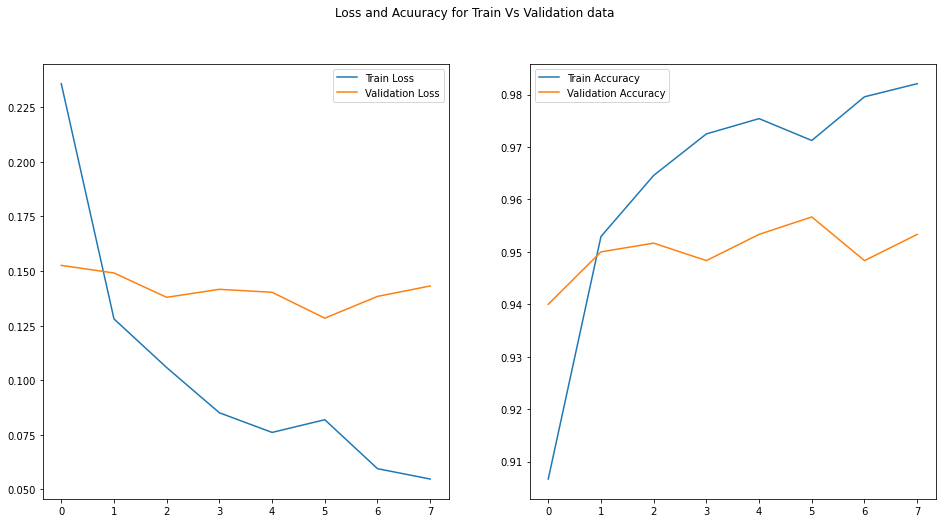

In [67]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Acuuracy for Train Vs Validation data')
figsize=(16,16),
ax1.plot(h_2.history['loss'], label = 'Train Loss'),
ax1.plot(h_2.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(h_2.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(h_2.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();

In [57]:
# Transfer learning EfficientNetB0 model with 15 epochs
model_2_15 = Sequential()
model_2_15.add(effnet)
model_2_15.add(GlobalAveragePooling2D())# Required, not 100% sure why but may be becasue of teh shape going into teh final layer, all it does is get teh shape right
# Flatten
model_2_15.add(Flatten())

# Fully Connected
model_2_15.add(Dense(64, activation='relu'))
model_2_15.add(Dense(1, activation='sigmoid'))

#Compile
model_2_15.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [58]:
# Fitting the model
h_2_15 = model_2_15.fit(train_ds, validation_data= val_ds, epochs = 15)

Epoch 1/15
75/75 [==============================] - 11s 68ms/step - loss: 0.2248 - accuracy: 0.9104 - val_loss: 0.1377 - val_accuracy: 0.9467
Epoch 2/15
75/75 [==============================] - 4s 47ms/step - loss: 0.1394 - accuracy: 0.9450 - val_loss: 0.1317 - val_accuracy: 0.9517
Epoch 3/15
75/75 [==============================] - 4s 49ms/step - loss: 0.1082 - accuracy: 0.9600 - val_loss: 0.1220 - val_accuracy: 0.9567
Epoch 4/15
75/75 [==============================] - 4s 47ms/step - loss: 0.0869 - accuracy: 0.9712 - val_loss: 0.1199 - val_accuracy: 0.9533
Epoch 5/15
75/75 [==============================] - 4s 48ms/step - loss: 0.0748 - accuracy: 0.9742 - val_loss: 0.1257 - val_accuracy: 0.9650
Epoch 6/15
75/75 [==============================] - 4s 52ms/step - loss: 0.0678 - accuracy: 0.9775 - val_loss: 0.1249 - val_accuracy: 0.9600
Epoch 7/15
75/75 [==============================] - 4s 52ms/step - loss: 0.0569 - accuracy: 0.9833 - val_loss: 0.1414 - val_accuracy: 0.9483
Epoch 8/15
7

In [59]:
# Scoring model
print(h_2_15.history['loss'][-1], h_2_15.history['val_loss'][-1])
print(h_2_15.history['accuracy'][-1], h_2_15.history['val_accuracy'][-1])

0.028046073392033577 0.16080106794834137
0.9912499785423279 0.9516666531562805


### Sticking with 8 epochs on transfer learning model

# Testing model with image

In [86]:
# Turn dog image into array to feed into model to predict
test_img_hot = img_to_array(load_img('/content/drive/MyDrive/datasets/hotdog-nothotdog/test/hotdog/1501.jpg'))
test_img_hot.shape

(299, 299, 3)

In [87]:
# Need to reshape image
test_img_hot = smart_resize(test_img_hot, (256,256))
test_img_hot.shape

(256, 256, 3)

In [88]:
# Adding extra dimension for model to work
test_image_hot = np.expand_dims(test_img_hot, axis = 0)
test_image_hot.shape

(1, 256, 256, 3)

In [89]:
# Predicting if image is dog
model_2.predict(test_image_hot)

1/1 [==============================] - 0s 31ms/step


array([[0.9999534]], dtype=float32)

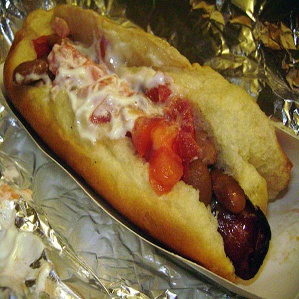

In [90]:
Image('/content/drive/MyDrive/datasets/hotdog-nothotdog/test/hotdog/1501.jpg')

The model is over 99% sure there is a hot dog in this image

---



In [91]:
# Turn not dog image into array to feed into model to predict
test_img_not = img_to_array(load_img('/content/drive/MyDrive/datasets/hotdog-nothotdog/test/nothotdog/151.jpg'))
test_img_not.shape

(299, 299, 3)

In [92]:
# Need to reshape image
test_img_not = smart_resize(test_img_not, (256,256))
test_img_not.shape

(256, 256, 3)

In [93]:
# Adding extra dimension for model to work
test_image_not = np.expand_dims(test_img_not, axis = 0)
test_image_not.shape

(1, 256, 256, 3)

In [95]:
# Predicting if image is not dog
model_2.predict(test_image_not)

1/1 [==============================] - 0s 32ms/step


array([[0.02523749]], dtype=float32)

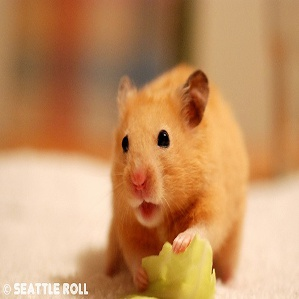

In [96]:
Image('/content/drive/MyDrive/datasets/hotdog-nothotdog/test/nothotdog/151.jpg')

The model is over 97% sure this is not a hot dog


# Now some challenging images

In [97]:
# Turn dog image into array to feed into model to predict
test_img_hot = img_to_array(load_img('/content/drive/MyDrive/datasets/hotdog-nothotdog/train/2 hotdog/1.jpg'))
test_img_hot.shape

(299, 299, 3)

In [98]:
# Need to reshape image
test_img_hot = smart_resize(test_img_hot, (256,256))
test_img_hot.shape

(256, 256, 3)

In [99]:
# Adding extra dimension for model to work
test_image_hot = np.expand_dims(test_img_hot, axis = 0)
test_image_hot.shape

(1, 256, 256, 3)

In [100]:
# Predicting if image is dog
model_2.predict(test_image_hot)

1/1 [==============================] - 0s 33ms/step


array([[0.42557877]], dtype=float32)

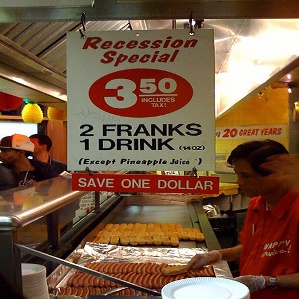

In [101]:
Image('/content/drive/MyDrive/datasets/hotdog-nothotdog/train/2 hotdog/1.jpg')

Our model is over 57% sure this is not a hot dog:(

In [102]:
# Turn not dog image into array to feed into model to predict
test_img_not = img_to_array(load_img('/content/drive/MyDrive/datasets/hotdog-nothotdog/hot_weiner.jpg'))
test_img_not.shape

(540, 540, 3)

In [103]:
# Need to reshape image
test_img_not = smart_resize(test_img_not, (256,256))
test_img_not.shape

(256, 256, 3)

In [104]:
# Adding extra dimension for model to work
test_image_not = np.expand_dims(test_img_not, axis = 0)
test_image_not.shape

(1, 256, 256, 3)

In [105]:
# Predicting if image is dog
model_2.predict(test_image_not)

1/1 [==============================] - 0s 31ms/step


array([[0.05609008]], dtype=float32)

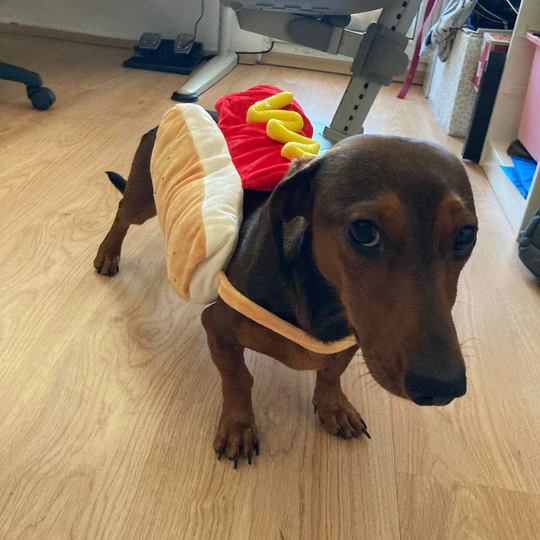

In [106]:

Image('/content/drive/MyDrive/datasets/hotdog-nothotdog/hot_weiner.jpg')

Our model is over 94% sure this is not a hot dog

In [121]:
#Saving model as tinsor flow type model
model_2.save('/content/drive/MyDrive/GA hotdogathon/real_model.h5')